![image](resources/qgss-header.png)

# Lab 4: Shor's Algorithm

In this lab, you will implement a quantum program to factor the number 15. In order to do this, you will write `Qiskit` code for Shor's algorithm following the material presented in lecture 4.

You might find the following chapters of the Qiskit Textbook useful:
- **Shor's algorithm**: https://qiskit.org/textbook/ch-algorithms/shor.html
- **Quantum phase estimation**: https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html
- **Quantum Fourier transform**: https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

Remember, to run a cell in Jupyter notebooks, you press `Shift` + `Return/Enter` on your keyboard.

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [1]:
!pip install -U -r grading_tools/requirements.txt

from IPython.display import clear_output
clear_output()

# Review of Shor's Algorithm

![image](resources/shor_circuit.png)

You might recall from lecture 4 that Shor's algorithm can be used to factor numbers $N$ that are products of the form 

$$N = pq$$

where $p$ and $q$ are prime numbers. This is done in four main steps, similar to the implementation of quantum phase estimation. In this case, we will use two registers of qubits. The first register will have $n$ qubits, and will contain the measurement qubits. The second register will have $m$ qubits, and will be the eigenstate for quantum phase estimation. 

1. First, we begin by initializing our qubits. We create a superposition of all $2^n$ computational basis states on the $n$ measurement qubits by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. We also initialize the $m$ target qubits in the state $\vert1\rangle$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits.

2. Second, we apply the unitary operator $U$ with various powers onto the target qubits by controlling it with each of the different measurement qubits. The unitary operator in this case implements modular exponentiation. The schematic above shows the ordering and respective powers.

3. Third, we apply an inverse quantum Fourier transform on the $n$ measurement qubits.

4. Finally, we measure the first $n$ qubits.

After the measurement outcomes are determined, we will need to do additional classical post-processing in order to determine the factors or to decide to run the program again.


# Graded Exercise 1: Implementing Shor's Algorithm

In this lab, we will implement Shor's algorithm and use it to factor 15 into 3 and 5.

### 1. Initializing the qubits

We will need to initialize our qubits as described above by applying a Hadamard gate on each of the $n$ measurement qubits. We will also set the target qubits to $\vert1\rangle$, since that is the eigenstate onto which the unitary operator $U$ will be applied. Here, $\vert1\rangle$ is initialized by applying an $X$ gate on the last qubit.

We have created a function below called `initialize_qubits` which takes in three arguments. The first argument is the quantum circuit onto which the gates will be applied. The second argument, `n`, is the number of measurement qubits. The third argument, `m`, is the number of target qubits for the unitary operator.

In [2]:
def initialize_qubits(given_circuit, n, m):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
        
    given_circuit.h(range(n))
    given_circuit.x(n+m-1)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

### 2. Modular exponentiation

We have created a function called `a_x_mod15` below which takes in two arguments, `a` and `x`, and implements the unitary operator $$U = a^x \text{ mod } 15$$

**You do not need to modify this function.**

In [3]:
from qiskit import QuantumCircuit

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

Note that the function `a_x_mod15` creates a 4-qubit unitary controlled by an additional fifth qubit. In order to use this gate, you will need to append it to your quantum circuit using `Qiskit`'s `circuit.append()` function by passing in the five qubits in a list containing the control qubit first, followed by the four target qubits.

Below, we have created a function called `modular_exponentiation` which takes in four arguments. The first argument, `given_circuit`, is the circuit onto which modular exponentiation will be applied. The next two arguments, `n` and `m`, are the numbers of measurement and target qubits. The schematic above for Shor's algorithm will be useful here. The last argument, `a`, is the base of the modular exponentiation. You will need to call the function `a_x_mod15` as needed in the function below.

In [4]:
def modular_exponentiation(given_circuit, n, m, a):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    for x in range(n):
        exponent = 2**x
        given_circuit.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))
        
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    

### 3. Implementing the inverse quantum Fourier transform

The last step before measuring the first $n$ qubits is the implementation of the inverse quantum Fourier transform. As with `lab3`, you can either implement it on your own or use `Qiskit`'s circuit library.

The function `apply_iqft` takes two arguments. The first argument, `given_circuit`, contains the qubits onto which the inverse quantum Fourier transform will be applied. The second argument, `measurement_qubits`, contains the list of qubits onto which the inverse quantum Fourier transform will be applied.

In [5]:
from qiskit.circuit.library import QFT

In [6]:
def apply_iqft(given_circuit, measurement_qubits):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    given_circuit.append(QFT( len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

### 4. Putting it all together

Finally, we combine the functions to construct the quantum program that implements Shor's algorithm.

The next lines of code put everything together. **You do not need to modify anything below, but you will need to run the cell to submit your solution.**

In [7]:
from qiskit import QuantumCircuit

In [8]:
def shor_program(n, m, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(shor, n, m)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    # apply inverse QFT
    apply_iqft(shor, range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor
    
n = 4; m = 4; a = 7
mycircuit = shor_program(n, m, a)
mycircuit.draw(output='text')

┌───┐ ░                                                              ░ »
q_0: ┤ H ├─░────────■─────────────────────────────────────────────────────░─»
     ├───┤ ░        │                                                     ░ »
q_1: ┤ H ├─░────────┼──────────────■──────────────────────────────────────░─»
     ├───┤ ░        │              │                                      ░ »
q_2: ┤ H ├─░────────┼──────────────┼──────────────■───────────────────────░─»
     ├───┤ ░        │              │              │                       ░ »
q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■────────░─»
     └───┘ ░ ┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐ ░ »
q_4: ──────░─┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├─░─»
           ░ │             ││             ││             ││             │ ░ »
q_5: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├─░─»
           ░ │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │ ░ »
q_6: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├─░─»
     ┌───┐ ░ │             ││             ││             ││             │ ░ »
q_7: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├─░─»
     └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘ ░ »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_2: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_3: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───────┐┌─┐         
«q_0: ┤0      ├┤M├─────────
«     │       │└╥┘┌─┐      
«q_1: ┤1      ├─╫─┤M├──────
«     │  iqft │ ║ └╥┘┌─┐   
«q_2: ┤2      ├─╫──╫─┤M├───
«     │       │ ║  ║ └╥┘┌─┐
«q_3: ┤3      ├─╫──╫──╫─┤M├
«     └───────┘ ║  ║  ║ └╥┘
«q_4: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_5: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_6: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_7: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«c_0: ══════════╩══╬══╬══╬═
«                  ║  ║  ║ 
«c_1: ═════════════╩══╬══╬═
«                     ║  ║ 
«c_2: ════════════════╩══╬═
«                        ║ 
«c_3: ═══════════════════╩═
«

That's it! In order to run your quantum circuit and get the measurement outcomes, you simply need to run `Qiskit`'s `execute` function as follows.

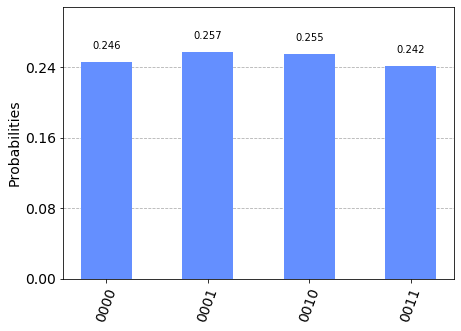

In [9]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [10]:
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 4
Measured 0
Measured 8
Measured 12


You can then follow the classical post-processing details described in lecture 4 to obtain the factors from the measurement outcomes. If you did everything correctly, you should have only measured 0, 4, 8 and 12.

#### Classical post-processing

Recall that in order to factor the number $N = pq$, we used a number $a$ coprime with $N$ and computed the period of $a^x \text{ mod } N$.

We will use the sequence of steps outlined in lecture 4 to guess the factors of $N$ using the measurement outcomes.

In [11]:
from math import gcd

for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Measured 4
(5, 3)
Measured 0
(1, 15)
Measured 8
(1, 15)
Measured 12
(5, 3)


#### That's it!

You can grade your solution by running the cell below after filling in your name and email address. **Always provide the same name and email as the one you used during registration to ensure consistency.**

In [12]:
name = 'Rajesh Vegi'
email = 'rajesh.vegi@gmail.com'

### Do not change the lines below
from grading_tools import grade
from qiskit import transpile
mycircuit_t = transpile(mycircuit, basis_gates = ['u1', 'u2', 'u3', 'cx'])
grade(answer=mycircuit_t, name=name, email=email, labid='lab4', exerciseid='ex1')

Grading...
lab4/ex1 - 🎉 Correct
🎊 Hurray! You have a new correct answer! Let's submit it.
Submitting the answers for lab4...
📝 Our records, so far, are:
Correct answers: lab1:ex1, lab2:ex1, lab3:ex1, lab4:ex1


# Additional reading

- The first experimental demonstration of Shor's algorithm was completed by researchers at IBM and Stanford in 2001 using an experimental platform called nuclear magnetic resonance. You can find the paper here: https://www.nature.com/articles/414883a
- For additional details on the method of continued fractions, you may refer to this page (https://riliu.math.ncsu.edu/437/notes3se4.html) or any standard reference such as Mermin's Quantum Computer Science text.